In [2]:
# === 1. LOAD & CLEAN DATA ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib

# Load the dataset
file_path = '/content/powerconsumption.csv'
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Parse datetime column
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

# Combine zone-wise power consumption to total
df['consumption'] = (
    df['powerconsumption_zone1'] +
    df['powerconsumption_zone2'] +
    df['powerconsumption_zone3']
)

# Use only datetime and total consumption for modeling
df = df[['datetime', 'consumption']].copy()
df = df.dropna()


# === 2. FEATURE ENGINEERING ===
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Lag features
df['lag1'] = df['consumption'].shift(1)
df['lag24'] = df['consumption'].shift(24)
df['lag168'] = df['consumption'].shift(168)

# Rolling mean features
df['rolling_3'] = df['consumption'].rolling(window=3).mean()
df['rolling_24'] = df['consumption'].rolling(window=24).mean()
df['rolling_168'] = df['consumption'].rolling(window=168).mean()

# Drop missing values
df = df.dropna()


# === 3. MODEL TRAINING ===
features = ['hour', 'dayofweek', 'month', 'year', 'is_weekend',
            'lag1', 'lag24', 'lag168', 'rolling_3', 'rolling_24', 'rolling_168']
X = df[features]
y = df['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save model and features for Streamlit app
joblib.dump(model, 'xgb_model.pkl')
joblib.dump(features, 'model_features.pkl')


# === 4. EVALUATION ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n✅ Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



✅ Model Evaluation:
R² Score: 0.9914
MAE: 1039.11
RMSE: 1543.25


In [3]:
# === 6. FORECASTING NEXT 7 DAYS (168 HOURS) ===

# Start from the latest row in the dataset
future_steps = 168  # 7 days hourly
last_known = df.iloc[-1].copy()

# Create a DataFrame to hold future timestamps and predictions
future_data = []

for i in range(1, future_steps + 1):
    next_datetime = last_known['datetime'] + pd.Timedelta(hours=1)

    # Create features for the next hour
    next_features = {
        'datetime': next_datetime,
        'hour': next_datetime.hour,
        'dayofweek': next_datetime.dayofweek,
        'month': next_datetime.month,
        'year': next_datetime.year,
        'is_weekend': 1 if next_datetime.dayofweek >= 5 else 0,
        'lag1': last_known['consumption'],
        'lag24': df.loc[df['datetime'] == next_datetime - pd.Timedelta(hours=24), 'consumption'].values[-1] if next_datetime - pd.Timedelta(hours=24) in df['datetime'].values else last_known['consumption'],
        'lag168': df.loc[df['datetime'] == next_datetime - pd.Timedelta(hours=168), 'consumption'].values[-1] if next_datetime - pd.Timedelta(hours=168) in df['datetime'].values else last_known['consumption'],
        'rolling_3': df['consumption'].iloc[-3:].mean(),
        'rolling_24': df['consumption'].iloc[-24:].mean(),
        'rolling_168': df['consumption'].iloc[-168:].mean()
    }

    # Create a DataFrame row
    feature_df = pd.DataFrame([next_features])
    X_future = feature_df[features]

    # Predict using the trained model
    y_future = model.predict(X_future)[0]
    next_features['consumption'] = y_future

    # Add to forecast
    future_data.append(next_features.copy())

    # Update last_known for next loop
    last_known = pd.Series(next_features)

# Convert to DataFrame
forecast_df = pd.DataFrame(future_data)
forecast_df.set_index('datetime', inplace=True)


<ipython-input-4-c62caebf6c9b>:9: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


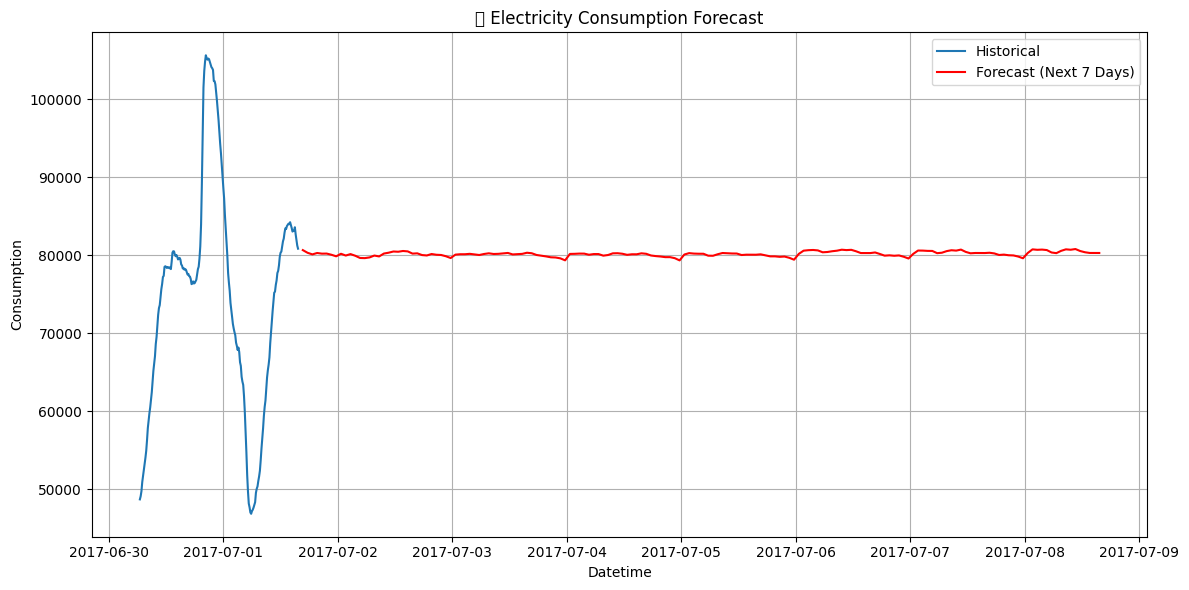

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'].iloc[-200:], df['consumption'].iloc[-200:], label='Historical')
plt.plot(forecast_df.index, forecast_df['consumption'], label='Forecast (Next 7 Days)', color='red')
plt.title("🔮 Electricity Consumption Forecast")
plt.xlabel("Datetime")
plt.ylabel("Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import joblib

# Save the trained model
joblib.dump(model, 'xgb_model.pkl')

# Save the list of feature columns used for prediction
joblib.dump(features, 'model_features.pkl')
import joblib
joblib.dump(model, 'xgb_model.pkl')
joblib.dump(features, 'model_features.pkl')


['model_features.pkl']

In [6]:
from google.colab import files
files.download('model_features.pkl')
files.download('xgb_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>